In [1]:
!pip install opencv-python>=3.4.2.17
!pip install libsvm>=3.23.0

In [2]:
import collections
from itertools import chain
import urllib.request as request
import pickle 

import numpy as np

import scipy.signal as signal
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

import cv2

from libsvm import svmutil

# Оценка качества изображения

Качество изображения - понятие, сильно зависящее от человека-наблюдателя. Обычно,
оно связано с условиями, в которых рассматривается изображение; следовательно, это весьма субъективная тема. Оценка качества изображения направлена на количественное представление человеческого восприятия качества. Эти показатели обычно используются для анализа производительности алгоритмов в различных областях компьютерного зрения, таких как сжатие изображений, передача изображений и обработка изображений [1].

Оценка качества изображения (Image quality assessment -- IQA) можно разделить на две основные области исследований (1) оценка на основе референсного изображения и (2) оценка без референсного изображения. Основное отличие состоит в том, что методы, основанные на референсных изображений, зависят от высококачественного изображения, который служит основой для оценки разницы между изображениями. Примером оценок, основанных на референсных изображениях, является индекс структурного сходства (Structural Similarity Index -- SSIM) [2].

## Оценка качества изображения без референса

Для оценки качества изображения без референса не требуется исходное эталонное изображение для оценки качества изображения. Всё, что получает на вход алгоритм, - это искаженное изображение, качество которого необходимо оценить.

Слепые методы (blind methods) как правило состоят из двух этапов. На первом этапе вычисляются признаки, которые описывают структуру изображения. Второй этап заключается в том, что эти признаки соотносятся с человеческим мнением о качестве изображения. TID2008 - это известная база данных, созданная в соответствии с методологией, описывающей измерение оценки человеческого мнения по референсным изображениям [3], она широко используется для сравнения производительности алгоритмов IQA.

## Blind/referenceless image spatial quality evaluator (BRISQUE)

BRISQUE [4] - это модель, которая использует только пиксели изображения для вычисления функций (другие методы основаны на преобразовании изображения в другие пространства, такие как вейвлет или DCT). Она очень эффективна, поскольку не требует преобразований для расчета своих характеристик.

Она основана на модели пространственной статистики естественной сцены(?????) (Natural Scene Statistics -- NSS) локально нормированных коэффициентов яркости в пространственной области, а также модели для попарных произведений этих коэффициентов.

## Методология
### Natural Scene Statistics in the Spatial Domain

Для данного изображения $I(i, j)$ сначала вычислим локально нормализованную яркость $\hat{I}(i, j)$ с помощью локального вычитания среднего $\mu(i,j)$ и разделим его на локальное отклонение $\sigma(i, j)$. $C$ добавляется, чтобы избежать деление на ноль.

$$\hat{I}(i,j) = \frac{I(i,j) - \mu(i,j)}{\sigma(i,j) + C}$$

*Если область определения $I(i,j)$ [0,255],то $C=1$ если область определения [0,1], то $C=1/255$.*

Чтобы вычислить локально нормализованную яркость (тоже самое, что коэффициенты нормализованного среднего вычитаемого контраста (mean substracted contrast normalized - MSCN)) сначала нам нужно вычислить локальное среднее.

$$\mu(i,j) = \sum_{k=-K}^{K}\sum_{l=-L}^{L}w_{k,l}I_{k,l}(i,j)$$

где $w$ это Гауссовское ядро размера (K, L).

То есть, просто применяем фильтр Гаусса к изображению.

In [3]:
def normalize_kernel(kernel):
    return kernel / np.sum(kernel)

def gaussian_kernel2d(n, sigma):
    Y, X = np.indices((n, n)) - int(n/2)
    gaussian_kernel = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2)) 
    return normalize_kernel(gaussian_kernel)

Затем вычисляем локальное отклонение:

$$ \sigma(i,j) = \sqrt{\sum_{k=-K}^{K}\sum_{l=-L}^{L}w_{k,l}(I_{k,l}(i, j) - \mu(i, j))^2 } $$

In [4]:
def local_deviation(image, local_mean, kernel):
    "Vectorized approximation of local deviation"
    sigma = image ** 2
    sigma = signal.convolve2d(sigma, kernel, 'same')
    return np.sqrt(np.abs(local_mean ** 2 - sigma))

Наконец, мы вычисляем коэффициенты MSCN

$$\hat{I}(i,j) = \frac{I(i,j) - \mu(i,j)}{\sigma(i,j) + C}$$

In [5]:
def calculate_mscn_coefficients(image, kernel_size=6, sigma=7/6):
    C = 1/255
    kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
    local_mean = signal.convolve2d(image, kernel, 'same')
    local_var = local_deviation(image, local_mean, kernel)
    
    return (image - local_mean) / (local_var + C)

Обнаружилось, что коэффициенты MSCN распределяются как обобщенное гауссово распределение (Generalized Gaussian Distribution -- GGD) для более широкого спектра искаженного изображения.


$$f(x; \alpha, \sigma^2) = \frac{\alpha}{2\beta\Gamma(1/\alpha)}e^{-\big(\frac{|x|}{\beta}\big)^\alpha}$$

где

$$\beta = \sigma \sqrt{\frac{\Gamma\big(\frac{1}{\alpha}\big)}{\Gamma\big(\frac{3}{\alpha}\big)}}$$

и $\Gamma$ - это гамма-функция.


Вид $\alpha$ влияет на вид и дисперсию $\sigma^2$.

### Попарные произведения соседних коэффициентов MSCN

Знаки соседних коэффициентов также имеют стандартную структуру, которая нарушается при наличии искажений. Предлагается использовать модель попарного произведения соседних коэффициентов MSCN по четырем направлениям (1) по горизонтали $H$, (2) по вертикали $V$, (3) по главной диагонали $D1$ и (4) по вторичной диагонали $D2$ .

$$H(i,j) = \hat{I}(i,j) \hat{I}(i, j + 1)$$
$$V(i,j) = \hat{I}(i,j) \hat{I}(i + 1, j)$$
$$D1(i,j) = \hat{I}(i,j) \hat{I}(i + 1, j + 1)$$
$$D2(i,j) = \hat{I}(i,j) \hat{I}(i + 1, j - 1)$$

In [6]:
def generalized_gaussian_dist(x, alpha, sigma):
    beta = sigma * np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    
    coefficient = alpha / (2 * beta() * special.gamma(1 / alpha))
    return coefficient * np.exp(-(np.abs(x) / beta) ** alpha)

In [7]:
def calculate_pair_product_coefficients(mscn_coefficients):
    return collections.OrderedDict({
        'mscn': mscn_coefficients,
        'horizontal': mscn_coefficients[:, :-1] * mscn_coefficients[:, 1:],
        'vertical': mscn_coefficients[:-1, :] * mscn_coefficients[1:, :],
        'main_diagonal': mscn_coefficients[:-1, :-1] * mscn_coefficients[1:, 1:],
        'secondary_diagonal': mscn_coefficients[1:, :-1] * mscn_coefficients[:-1, 1:]
    })

Отмечено, что обобщенное распределение Гаусса не обеспечивает хорошего соответствия эмпирическим гистограммам произведений коэффициентов. Таким образом, предлагается модель асимметричного обобщенного гауссова распределения (Asymmetric Generalized Gaussian Distribution - AGGD) [5].

$$
f(x; \nu, \sigma_l^2, \sigma_r^2) =  
   \begin{cases} 
      \frac{\nu}{(\beta_l + \beta_r)\Gamma\big(\frac{1}{\nu}\big)}e^{\big(-\big(\frac{-x}{\beta_l}\big)^\nu\big)} & x < 0 \\
        \frac{\nu}{(\beta_l + \beta_r)\Gamma\big(\frac{1}{\nu}\big)}e^{\big(-\big(\frac{x}{\beta_r}\big)^\nu\big)} & x >= 0
\end{cases}
$$

где

$$\beta_{side} = \sigma_{side} \sqrt{\frac{\Gamma\big(\frac{1}{\nu}\big)}{\Gamma\big(\frac{3}{\nu}\big)}}$$

и $side$ может быть как $r$, так и $l$.

Еще один параметр, который не отражен в предыдущей формуле, - среднее значение.

$$\eta = (\beta_r - beta_l) \frac{\Gamma\big(\frac{2}{\nu}\big)}{\Gamma\big(\frac{1}{\nu}\big)}$$

In [8]:
def asymmetric_generalized_gaussian(x, nu, sigma_l, sigma_r):
    def beta(sigma):
        return sigma * np.sqrt(special.gamma(1 / nu) / special.gamma(3 / nu))
    
    coefficient = nu / ((beta(sigma_l) + beta(sigma_r)) * special.gamma(1 / nu))
    f = lambda x, sigma: coefficient * np.exp(-(x / beta(sigma)) ** nu)
        
    return np.where(x < 0, f(-x, sigma_l), f(x, sigma_r))

### Fitting Asymmetric Generalized Gaussian Distribution


1. Вычислить $\hat{\gamma}$, где $N_l$ - количество отрицательных samples и $N_r$ количество положительных samples. 


$$
\hat{\gamma} = \frac{\sqrt{\frac{1}{N_l - 1}\sum_{k=1, x_k < 0}^{N_l} x_k^2}
}{\sqrt{\frac{1}{N_r - 1}\sum_{k=1, x_k >= 0}^{N_r} x_k^2}
}
$$

2. Вычислить $\hat{r}$.

$$\hat{r} = \frac{\big(\frac{\sum|x_k|}{N_l + N_r}\big)^2}{\frac{\sum{x_k ^ 2}}{N_l + N_r}} $$

3. Вычислить $\hat{R}$, используя оценки $\hat{\gamma}$ и $\hat{r}$.

$$\hat{R} = \hat{r} \frac{(\hat{\gamma}^3 + 1)(\hat{\gamma} + 1)}{(\hat{\gamma}^2 + 1)^2}$$

4. Оценить $\alpha$, используя приближение обратного обобщенного отношения Гаусса.

$$\hat{\alpha} = \hat{\rho} ^ {-1}(\hat{R})$$

$$\rho(\alpha) = \frac{\Gamma(2 / \alpha) ^ 2}{\Gamma(1 / \alpha) \Gamma(3 / \alpha)}$$

5. Оценить левые и правые параметры шкалы.
$$\sigma_l = \sqrt{\frac{1}{N_l - 1}\sum_{k=1, x_k < 0}^{N_l} x_k^2}$$
$$\sigma_r = \sqrt{\frac{1}{N_r - 1}\sum_{k=1, x_k >= 0}^{N_r} x_k^2}$$

In [9]:
def asymmetric_generalized_gaussian_fit(x):
    def estimate_phi(alpha):
        numerator = special.gamma(2 / alpha) ** 2
        denominator = special.gamma(1 / alpha) * special.gamma(3 / alpha)
        return numerator / denominator

    def estimate_r_hat(x):
        size = np.prod(x.shape)
        return (np.sum(np.abs(x)) / size) ** 2 / (np.sum(x ** 2) / size)

    def estimate_R_hat(r_hat, gamma):
        numerator = (gamma ** 3 + 1) * (gamma + 1)
        denominator = (gamma ** 2 + 1) ** 2
        return r_hat * numerator / denominator

    def mean_squares_sum(x, filter = lambda z: z == z):
        filtered_values = x[filter(x)]
        squares_sum = np.sum(filtered_values ** 2)
        return squares_sum / ((filtered_values.shape))

    def estimate_gamma(x):
        left_squares = mean_squares_sum(x, lambda z: z < 0)
        right_squares = mean_squares_sum(x, lambda z: z >= 0)

        return np.sqrt(left_squares) / np.sqrt(right_squares)

    def estimate_alpha(x):
        r_hat = estimate_r_hat(x)
        gamma = estimate_gamma(x)
        R_hat = estimate_R_hat(r_hat, gamma)

        solution = optimize.root(lambda z: estimate_phi(z) - R_hat, [0.2]).x

        return solution[0]

    def estimate_sigma(x, alpha, filter = lambda z: z < 0):
        return np.sqrt(mean_squares_sum(x, filter))
    
    def estimate_mean(alpha, sigma_l, sigma_r):
        return (sigma_r - sigma_l) * constant * (special.gamma(2 / alpha) / special.gamma(1 / alpha))
    
    alpha = estimate_alpha(x)
    sigma_l = estimate_sigma(x, alpha, lambda z: z < 0)
    sigma_r = estimate_sigma(x, alpha, lambda z: z >= 0)
    
    constant = np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    mean = estimate_mean(alpha, sigma_l, sigma_r)
    
    return alpha, mean, sigma_l, sigma_r

### Вычисление BRISQUE характеристик

The features needed to calculate the image quality are the result of fitting the MSCN coefficients and shifted products to the Generalized Gaussian Distributions. First, we need to fit the MSCN coefficients to the GDD, then the pairwise products to the AGGD. A summary of the features is the following:

Характеристики, необходимые для расчета качества изображения, являются результатом подгонки коэффициентов MSCN и смещенных произведений к обобщенному гауссовскому распределению. Во-первых, нам нужно подогнать коэффициенты MSCN к GDD, а затем попарные произведения к AGGD. Краткое описание функций следующее:

|ID Характеристики| Описание Характеристики                        | Расчёт                           |
|-----------------|------------------------------------------------|----------------------------------|
| $f_1-f_2$       | Вид и дисперсия                                   | Fit GGD to MSCN coefficients     |
| $f_3-f_6$       | Вид, среднее, левая дисперсия, правая дисперсия| Fit AGGD to H pairwise products  |
| $f_7-f_{10}$    | Вид, среднее, левая дисперсия, правая дисперсия| Fit AGGD to V pairwise products  |
| $f_{11}-f_{14}$ | Вид, среднее, левая дисперсия, правая дисперсия| Fit AGGD to D1 pairwise products |
| $f_{15}-f_{18}$ | Вид, среднее, левая дисперсия, правая дисперсия| Fit AGGD to D2 pairwise products |

In [10]:
def calculate_brisque_features(image, kernel_size=7, sigma=7/6):
    def calculate_features(coefficients_name, coefficients, accum=np.array([])):
        alpha, mean, sigma_l, sigma_r = asymmetric_generalized_gaussian_fit(coefficients)

        if coefficients_name == 'mscn':
            var = (sigma_l ** 2 + sigma_r ** 2) / 2
            return [alpha, var]
        
        return [alpha, mean, sigma_l ** 2, sigma_r ** 2]
    
    mscn_coefficients = calculate_mscn_coefficients(image, kernel_size, sigma)
    coefficients = calculate_pair_product_coefficients(mscn_coefficients)
    
    features = [calculate_features(name, coeff) for name, coeff in coefficients.items()]
    flatten_features = list(chain.from_iterable(features))
    return np.array(flatten_features)

# Анализ

После создания всех функций, необходимых для расчета brisque характеристик, мы можем оценить качество изображения для данного изображения. В [4] используется изображение из Kodak dataset [6].

## Вспомогательные функции

In [11]:
def load_image(url):
    image_stream = request.urlopen(url)
    return skimage.io.imread(image_stream, plugin='pil')

def plot_histogram(x, label):
    n, bins = np.histogram(x.ravel(), bins=50)
    n = n / np.max(n)
    plt.plot(bins[:-1], n, label=label, marker='o')

## 1. Загружаем картинку

In [12]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 9

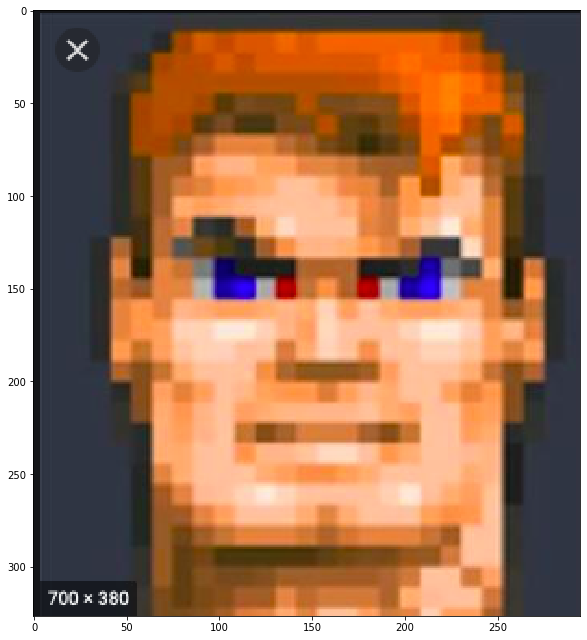

In [13]:
image = skimage.io.imread('/Users/annabukreeva/Desktop/bad.png', plugin='pil')
gray_image = skimage.color.rgb2gray(image)
skimage.io.imshow(image)

## 2. Вычисляем коэффициенты

In [14]:
%%time 

mscn_coefficients = calculate_mscn_coefficients(gray_image, 7, 7/6)
coefficients = calculate_pair_product_coefficients(mscn_coefficients)

CPU times: user 42.3 ms, sys: 4.43 ms, total: 46.7 ms
Wall time: 50.8 ms


In [15]:
coefficients

OrderedDict([('mscn',
              array([[ 1.00763914,  0.71736332,  0.58067068, ...,  0.283561  ,
                       0.36661503,  0.63777181],
                     [ 0.72853521,  0.37166898,  0.10065627, ..., -0.43098871,
                      -0.28739348,  0.0684677 ],
                     [ 0.64788239,  0.21438753, -0.16745539, ...,  0.44594165,
                       0.54930313,  0.85088439],
                     ...,
                     [ 0.64788239,  0.27114056, -0.05473798, ...,  0.13614958,
                       0.31226366,  0.69553025],
                     [ 0.72853521,  0.39064648,  0.17376372, ...,  0.31508004,
                       0.43265692,  0.77934761],
                     [ 1.00763914,  0.71442633,  0.5648004 , ...,  0.68333497,
                       0.76574113,  1.07303015]])),
             ('horizontal',
              array([[ 0.72284336,  0.41655185,  0.2589471 , ...,  0.07664326,
                       0.10395773,  0.23381673],
                     [ 0.

После вычисления коэффициентов MSCN и попарных произведений мы можем убедиться, что распределения действительно разные.

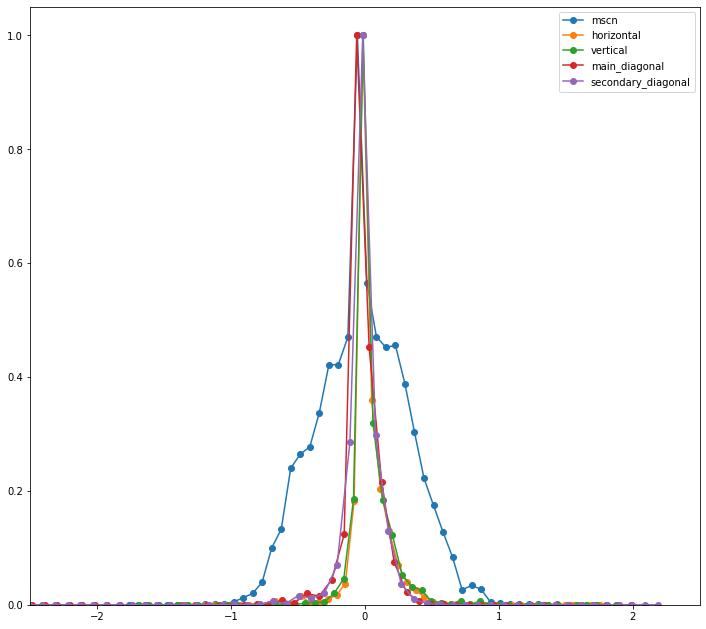

In [16]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 11

for name, coeff in coefficients.items():
    plot_histogram(coeff.ravel(), name)

plt.axis([-2.5, 2.5, 0, 1.05])
plt.legend()
plt.show()

## 3. Коэффициенты и GGD

In [17]:
%%time 

brisque_features = calculate_brisque_features(gray_image, kernel_size=7, sigma=7/6)

CPU times: user 56.5 ms, sys: 7.63 ms, total: 64.1 ms
Wall time: 67.1 ms


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


## 4. Изменение размера изображения и вычисление BRISQUE характеристик

In [18]:
%%time

downscaled_image = cv2.resize(gray_image, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
downscale_brisque_features = calculate_brisque_features(downscaled_image, kernel_size=7, sigma=7/6)

brisque_features = np.concatenate((brisque_features, downscale_brisque_features))

CPU times: user 20.7 ms, sys: 3.72 ms, total: 24.4 ms
Wall time: 23.6 ms


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


## 5. SVR

Предлагается предварительно обученная модель SVR для расчета оценки качества. Однако для получения хороших результатов нам нужно масштабировать функции до [-1, 1]. Для последнего нам нужны те же параметры, которые использовались для масштабирования вектора признаков.

In [19]:
def scale_features(features):
    with open('normalize.pickle', 'rb') as handle:
        scale_params = pickle.load(handle)
    
    min_ = np.array(scale_params['min_'])
    max_ = np.array(scale_params['max_'])
    
    return -1 + (2.0 / (max_ - min_) * (features - min_))

def calculate_image_quality_score(brisque_features):
    model = svmutil.svm_load_model('brisque_svm.txt')
    scaled_brisque_features = scale_features(brisque_features)
    
    x, idx = svmutil.gen_svm_nodearray(
        scaled_brisque_features,
        isKernel=(model.param.kernel_type == svmutil.PRECOMPUTED))
    
    nr_classifier = 1
    prob_estimates = (svmutil.c_double * nr_classifier)()
    
    return svmutil.libsvm.svm_predict_probability(model, x, prob_estimates)

Масштаб, используемый для представления качества изображения, изменяется от 0 до 100. Качество изображения 100 означает, что качество изображения очень плохое. В случае анализируемого изображения мы получаем, что это изображение плохого качества. Это имеет смысл, потому что мы используем искаженное изображение.

In [20]:
%%time

calculate_image_quality_score(brisque_features)

CPU times: user 8.1 ms, sys: 3.85 ms, total: 12 ms
Wall time: 14.8 ms


52.56468655493822

In [22]:
image = None
Im = None
edgex, edgey = None, None

In [23]:
def load(img, blur=False, blurSize=(5,5)):
    if isinstance(img, str):
        if os.path.exists(img):
            image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        else:
            raise FileNotFoundError('Image is not found on your system')
    elif isinstance(img, np.ndarray):
        if len(img.shape) == 3:
            image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        elif len(img.shape) == 2:
            image = img
        else:
            raise ValueError('Image is not in correct shape')
    else:
        raise ValueError('Only image can be passed to the constructor')

    if blur:
        image = cv2.GaussianBlur(image, blurSize)

    Im = cv2.medianBlur(image, 3, cv2.CV_64F).astype("double")/255.0
    return image, Im


In [24]:
def dom(Im):
        median_shift_up = np.pad(Im, ((0,2), (0,0)), 'constant')[2:,:]
        median_shift_down = np.pad(Im, ((2,0), (0,0)), 'constant')[:-2,:]
        domx = np.abs(median_shift_up - 2*Im + median_shift_down)
        
        median_shift_left = np.pad(Im, ((0,0), (0,2)), 'constant')[:,2:]
        median_shift_right = np.pad(Im, ((0,0), (2,0)), 'constant')[:,:-2]
        domy = np.abs(median_shift_left - 2*Im + median_shift_right)
        
        return domx, domy

In [25]:
def get_sharpness(img):
    image, Im = load(img)
    edges(image, edge_threshold=0.0001)
    score = sharpness_measure(Im, width=2, sharpness_threshold=2)
    return score

In [26]:
def contrast(Im):
        Cx = np.abs(Im - np.pad(Im, ((1,0), (0,0)), 'constant')[:-1, :])
        Cy = np.abs(Im - np.pad(Im, ((0,0), (1,0)), 'constant')[:, :-1])
        return Cx, Cy

In [27]:
def smoothenImage(image, transpose = False, epsilon = 1e-8):
    fil = np.array([0.5, 0, -0.5]) # Smoothing Filter

    if transpose:
        image = image.T

    image_smoothed = np.array([np.convolve(image[i], fil, mode="same") for i in range(image.shape[0])])

    if transpose:
        image_smoothed = image_smoothed.T

    image_smoothed = np.abs(image_smoothed)/(np.max(image_smoothed) + epsilon)
    return image_smoothed



In [28]:
def edges(image, edge_threshold=0.0001):
    smoothx = smoothenImage(image, transpose=True)
    smoothy = smoothenImage(image)
    global edgex
    edgex = smoothx > edge_threshold
    global edgey
    edgey = smoothy > edge_threshold

In [29]:
def sharpness_matrix(Im, width=2, debug=False):
    domx, domy = dom(Im)

    Cx, Cy = contrast(Im)

    Cx = np.multiply(Cx, edgex)
    Cy = np.multiply(Cy, edgey)

    Sx = np.zeros(domx.shape)
    Sy = np.zeros(domy.shape)

    for i in range(width, domx.shape[0]-width):
        num = np.abs(domx[i-width:i+width, :]).sum(axis=0)
        dn = Cx[i-width:i+width, :].sum(axis=0)
        Sx[i] = [(num[k]/dn[k] if dn[k] > 1e-3 else 0) for k in range(Sx.shape[1])]
    for j in range(width, domy.shape[1]-width):
        num = np.abs(domy[:, j-width: j+width]).sum(axis=1)
        dn = Cy[:, j-width:j+width].sum(axis=1)
        Sy[:, j] = [(num[k]/dn[k] if dn[k] > 1e-3 else 0) for k in range(Sy.shape[0])]

    return Sx, Sy

In [30]:
def sharpness_measure(Im, width, sharpness_threshold, debug=False, epsilon = 1e-8):
    Sx, Sy = sharpness_matrix(Im, width=width, debug=debug)
    Sx = np.multiply(Sx, edgex)
    Sy = np.multiply(Sy, edgey)

    n_sharpx = np.sum(Sx >= sharpness_threshold)
    n_sharpy = np.sum(Sy >= sharpness_threshold)

    n_edgex = np.sum(edgex)
    n_edgey = np.sum(edgey)

    Rx = n_sharpx/(n_edgex + epsilon)
    Ry = n_sharpy/(n_edgey + epsilon)

    S = np.sqrt(Rx**2 + Ry**2)

    if debug:
        print(f"Sharpness: {S}")
        print(f"Rx: {Rx}, Ry: {Ry}")
        print(f"Sharpx: {n_sharpx}, Sharpy: {n_sharpy}, Edges: {n_edgex, n_edgey}")
    return S

In [31]:
def get_sharpness(img, width=2, sharpness_threshold=2, edge_threshold=0.0001, debug=False):
    image, Im = load(img)
    edges(image, edge_threshold=edge_threshold)
    score = sharpness_measure(Im, width=width, sharpness_threshold=sharpness_threshold)
    return score

In [32]:
f = cv2.imread('/Users/annabukreeva/Desktop/bad.png', 1)
ssss = get_sharpness(f)

In [33]:
ssss

0.8781318363957068

In [46]:
def estimate_noise(I):
    H, W = I.shape
    M = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]

    sigma = np.sum(np.sum(np.absolute(convolve2d(I, M))))
    sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))

    return sigma

 "> 10 зашумленная, иначе нет"
 https://www.sciencedirect.com/science/article/pii/S1077314296900600

In [51]:
import math
from scipy.signal import convolve2d
img = cv2.imread('/Users/annabukreeva/Desktop/good.png', 1)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
noise = estimate_noise(img_gray)

In [52]:
noise

0.39024972674676056

In [58]:
img_noisy = cv2.imread('/Users/annabukreeva/Documents/Курсач/noisy_high.png', 1)
img_noisy_gray = cv2.cvtColor(img_noisy, cv2.COLOR_BGR2GRAY)
noise1 = estimate_noise(img_noisy_gray)
noise1

3.562186733419569

In [59]:
img_norm = cv2.imread('/Users/annabukreeva/Documents/Курсач/noisy_normal.png', 1)
img_norm_gray = cv2.cvtColor(img_norm, cv2.COLOR_BGR2GRAY)
noise2 = estimate_noise(img_norm_gray)
noise2

0.763092768072314

In [60]:
img_perf = cv2.imread('/Users/annabukreeva/Downloads/kodim05.png', 1)
img_perf_gray = cv2.cvtColor(img_perf, cv2.COLOR_BGR2GRAY)
noise3 = estimate_noise(img_perf_gray)
noise3

4.740414388356415

In [61]:
import cv2
from skimage.restoration import estimate_sigma

def estimate_noise(image_path):
    img = cv2.imread(image_path)
    return estimate_sigma(img, multichannel=True, average_sigmas=True)

In [62]:
estimate_noise('/Users/annabukreeva/Downloads/kodim05.png')

3.282791184986434

In [63]:
estimate_noise('/Users/annabukreeva/Documents/Курсач/noisy_normal.png')

0.8046996166263689

In [64]:
estimate_noise('/Users/annabukreeva/Documents/Курсач/noisy_high.png')

4.09549132034365

Порог варьируется от того, насколько качественную картинку мы

Нельзя использовать в одиночестве, т.к. он оценивает только шум